Z powodu MemoryError przy bazie danych z 32 ml filmów, zadanie zrobiłam także na mniejszym zbiorze.

In [37]:
import pandas as pd
import requests
import io
import zipfile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
data_folder = 'ml-100k/'
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
with zip_file.open(data_folder + 'u.data') as f:
    ratings_df = pd.read_csv(f, sep='\t', header=None, names=rating_cols)

item_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
             'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
             'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
with zip_file.open(data_folder + 'u.item') as f:
    movies_df = pd.read_csv(f, sep='|', encoding='latin-1', header=None, names=item_cols)

print(ratings_df.head())
print(movies_df.head())


   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0    

In [2]:
sci_fi_count = movies_df['Sci-Fi'].sum()
print(f"Liczba filmów Sci-Fi: {int(sci_fi_count)}")

Liczba filmów Sci-Fi: 101


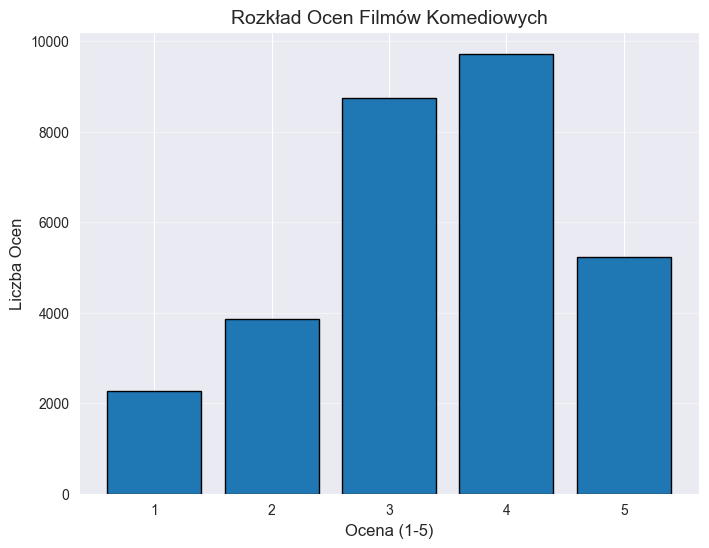

In [3]:
import matplotlib.pyplot as plt
comedy_ratings_df = ratings_df.merge(movies_df[['movie_id', 'Comedy']], on='movie_id')
comedy_ratings = comedy_ratings_df[comedy_ratings_df['Comedy'] == 1]['rating']

plt.figure(figsize=(8, 6))
plt.hist(comedy_ratings, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', rwidth=0.8)
plt.title('Rozkład Ocen Filmów Komediowych', fontsize=14)
plt.xlabel('Ocena (1-5)', fontsize=12)
plt.ylabel('Liczba Ocen', fontsize=12)
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', alpha=0.5)
plt.show()

In [5]:
movie_stats = ratings_df.groupby('movie_id')['rating'].agg(['count', 'mean']).reset_index()
movie_stats.columns = ['movie_id', 'count', 'mean']

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(rating):
    bayesian_avg = (C * m + rating.sum()) / (C + rating.count())
    return bayesian_avg
bayesian_avg_ratings = ratings_df.groupby('movie_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movie_id', 'bayesian_avg']
final_df = movie_stats.merge(bayesian_avg_ratings, on='movie_id')

print(f"\nParametry Bayesian Average:")
print(f"Średnia liczba ocen na film (C): {C:.2f}")
print(f"Średnia ocena wszystkich filmów (m): {m:.2f}")
movie_stats = movie_stats.merge(movies_df[['movie_id', 'title']], on='movie_id')


Parametry Bayesian Average:
Średnia liczba ocen na film (C): 59.45
Średnia ocena wszystkich filmów (m): 3.08


In [14]:
action_ratings_all = ratings_df.merge(movies_df[['movie_id', 'Action']], on='movie_id')
action_ratings_all = action_ratings_all[action_ratings_all['Action'] == 1]['rating']
overall_avg_action_rating = action_ratings_all.mean()
print(f"Średnia ocena wszystkich filmów akcji: {overall_avg_action_rating:.2f}")

action_movies = final_df.merge(movies_df[movies_df['Action'] == 1][['movie_id', 'title']], on='movie_id', how='inner')
top_3_bayesian = action_movies.sort_values(by='bayesian_avg', ascending=False).head(3)

print("Top 3 Filmy Akcji według Bayesian Average:")
print(top_3_bayesian[['title', 'count', 'bayesian_avg']].to_markdown(index=False, floatfmt=".2f"))

Średnia ocena wszystkich filmów akcji: 3.48
Top 3 Filmy Akcji według Bayesian Average:
| title                          |   count |   bayesian_avg |
|:-------------------------------|--------:|---------------:|
| Star Wars (1977)               |     583 |           4.24 |
| Godfather, The (1972)          |     413 |           4.13 |
| Raiders of the Lost Ark (1981) |     420 |           4.11 |


In [15]:
import numpy as np
from scipy.sparse import csr_matrix
def create_sparse(df):
    """
    Generuje macierz rzadką w formacie CSR z ramki danych ocen.

    Args:
        df: pandas dataframe zawierający 3 kolumny (userId, movieId, rating)

    Returns:
        X: Macierz rzadka (csr_matrix)
        user_mapper, movie_mapper: Słowniki mapujące ID na indeksy (0-M/N)
        user_inv_mapper, movie_inv_mapper: Słowniki mapujące indeksy na ID
    """
    M = df['user_id'].nunique() # Liczba unikalnych użytkowników
    N = df['movie_id'].nunique() # Liczba unikalnych filmów

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movie_id"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movie_id"])))

    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [movie_mapper[i] for i in df['movie_id']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings_df)
sparsity = X.count_nonzero() / (X.shape[0] * X.shape[1])

print(f"Kształt macierzy X (Użytkownicy x Filmy): {X.shape[0]} x {X.shape[1]}")
print(f"Liczba niezerowych elementów: {X.count_nonzero()}")
print(f"Matrix sparsity (Rzadkość): {round(sparsity*100, 2)}%")


Kształt macierzy X (Użytkownicy x Filmy): 943 x 1682
Liczba niezerowych elementów: 100000
Matrix sparsity (Rzadkość): 6.3%


Algorytm kNN with means różni się od standardowego kNN tym, że zamiast klasyfikować nową próbkę na podstawie większości głosów k najbliższych sąsiadów, przypisuje jej klasę, której średnia cech (centroid) jest do niej najbliższa. W efekcie, w kNN with means, faktyczna klasyfikacja zależy od porównania odległości do centroidów, a nie od indywidualnych etykiet sąsiadów.

In [30]:
from surprise import Reader, Dataset
from surprise import SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV
import numpy as np

reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

print("1. SVD")
algo_svd = SVD(random_state=42)
cv_results_svd = cross_validate(algo_svd, data, measures=['RMSE'], cv=3, verbose=False)

mean_rmse_svd = np.mean(cv_results_svd['test_rmse'])
print(f"Średni RMSE (SVD): {mean_rmse_svd:.4f}")

print("2. Hiperparametryzacja kNNwithMeans (Grid Search)")

k_values = list(range(2, 7))
param_grid = {
    'k': k_values,
    'sim_options': {
        'name': ['pearson'],
        'user_based': [True]
    }
}

print(f"Testowane wartości k: {k_values}")
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

best_rmse = gs.best_score['rmse']
best_params_rmse = gs.best_params['rmse']
best_algo = gs.best_estimator['rmse']

print("\n--- WYNIKI OPTYMALIZACJI kNNwithMeans ---")
print(f"Najlepszy RMSE: {best_rmse:.4f}")
print(f"Optymalne parametry dla RMSE: {best_params_rmse}")
print(f"Wybrany optymalny model: {best_algo.__class__.__name__} z k={best_algo.k}")

1. SVD
Średni RMSE (SVD): 0.9450
2. Hiperparametryzacja kNNwithMeans (Grid Search)
Testowane wartości k: [2, 3, 4, 5, 6]
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity

In [31]:
pattern = r'\bJumanji\b'
jumanji_movies = movies_df[movies_df['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
if not jumanji_movies.empty:
    print(jumanji_movies[['movie_id', 'title']].to_markdown(index=False))
else:
    print("Brak filmów z dokładnym słowem 'Jumanji' w tytule.")

|   movie_id | title          |
|-----------:|:---------------|
|        755 | Jumanji (1995) |


In [32]:
pattern = r'\bFlint\b'
jumanji_movies = movies_df[movies_df['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
if not jumanji_movies.empty:
    print(jumanji_movies[['movie_id', 'title']].to_markdown(index=False))
else:
    print("Brak filmów z dokładnym słowem 'Flint' w tytule.")

Brak filmów z dokładnym słowem 'Flint' w tytule.


In [33]:
#Brak flimu Flint w bazie, zamiast tego pokażę to na przykładzie filmu 'Fantasia'
pattern = r'\bFantasia\b'
flint_movies = movies_df[movies_df['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
if not flint_movies.empty:
    print(flint_movies[['movie_id', 'title']].to_markdown(index=False))
else:
    print("Brak filmów z dokładnym słowem 'Fantasia' w tytule.")

|   movie_id | title           |
|-----------:|:----------------|
|        432 | Fantasia (1940) |


In [35]:
from surprise import KNNWithMeans

# Najlepsze parametry z Grid Search
best_params = {'k': 6, 'sim_options': {'name': 'pearson', 'user_based': True}}
optimal_algo = KNNWithMeans(**best_params, random_state=42)
trainset = data.build_full_trainset()
optimal_algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [36]:
movie_titles = dict(zip(movies_df['movie_id'], movies_df['title']))
jumanji_id = 755
fan_id = 432

def get_similar_movies_knn(model, top_n=5, target_ids=[]):
    """zoptymalizowany model Item-Based do znalezienia sąsiadów."""
    recommendations = {}

    for movie_id in target_ids:
        try:
            movie_inner_id = model.trainset.to_inner_iid(movie_id)
            neighbors_inner_ids = model.get_neighbors(movie_inner_id, k=top_n)

            neighbors_external_ids = [model.trainset.to_raw_iid(inner_id) for inner_id in neighbors_inner_ids]
            final_recs = [movie_titles[mid] for mid in neighbors_external_ids if mid != movie_id and mid in movie_titles]

            recommendations[movie_id] = final_recs
        except ValueError:
            recommendations[movie_id] = [f"Brak wystarczających danych do predykcji dla ID {movie_id}."]

    return recommendations


target_list = [jumanji_id, fan_id]
recs = get_similar_movies_knn(optimal_algo, top_n=5, target_ids=target_list)
print(f" k={optimal_algo.k}:")

print(f"Jeśli podobał Ci się {movie_titles[jumanji_id]} (ID: {jumanji_id}), rekomendujemy:")
for title in recs[jumanji_id]:
    print(f"- {title}")


print(f"Jeśli podobał Ci się {movie_titles[fan_id]} (ID: {fan_id}), rekomendujemy:")
for title in recs[fan_id]:
    print(f"- {title}")

 k=6:
Jeśli podobał Ci się Jumanji (1995) (ID: 755), rekomendujemy:
- Seven (Se7en) (1995)
- Once Upon a Time in America (1984)
- Game, The (1997)
- Braveheart (1995)
- City Hall (1996)
Jeśli podobał Ci się Fantasia (1940) (ID: 432), rekomendujemy:
- Wings of Desire (1987)
- Raiders of the Lost Ark (1981)
- Devil's Advocate, The (1997)
- Wrong Trousers, The (1993)
- Dazed and Confused (1993)
